## Project Week8 Markov chain

* We have anonymously tracked the movement of all DOODL customers during a five-day week. 
* In the following files you find tabular data indicating where customers spent their time. 

Our sales department is interested in a summary of the collected data. Please generate a report including numbers and diagrams. Note that your audience are not data scientists, so take care to prepare insights that are as clear as possible. We are interested in the following:
1. Calculate the total number of customers in each section
2. Calculate the total number of customers in each section over time
3. Display the number of customers at checkout over time
4. Calculate the time each customer spent in the market
5. Calculate the total number of customers present in the supermarket over time.
6. Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

Hint for working with the data:
* extract a single customer ID and see what you can get done for that one before trying the same for all.
* if you have a timestamp, this one usually belongs in the index.
* if you are wondering what happened in the minutes for which you have no data: all customers stay where they are.
* consider .resample() to fill up the minutes in between
* where was customer #7 on Monday at 7:06? This is a good customer to look at in more detail

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date

In [2]:
def datetime_index(df):
    df['datetime'] = pd.to_datetime(df['timestamp']) # convert column to datetime object
    df.set_index('datetime', inplace=True) # set column 'datetime' to index
    #del df['timestamp']


In [3]:
mon = pd.read_csv('data/monday.csv', sep=';', parse_dates=True)
tue = pd.read_csv('data/tuesday.csv', sep=';', parse_dates=True)
wed = pd.read_csv('data/wednesday.csv', sep=';', parse_dates=True)
thu = pd.read_csv('data/thursday.csv', sep=';', parse_dates=True)
fri = pd.read_csv('data/friday.csv', sep=';', parse_dates=True)

In [33]:
mon.groupby('customer_no').count()

,timestamp,location
customer_no,,
1,2,2
2,2,2
3,2,2
4,2,2
5,2,2
...,...,...
1443,2,2
1444,2,2
1445,1,1


In [13]:
# One complete dataframe:

df = pd.concat([mon, tue, wed, thu, fri])
df['datetime'] = pd.to_datetime(df['timestamp'])
df.head(2)

,timestamp,customer_no,location,datetime
0,2019-09-02 07:03:00,1,dairy,2019-09-02 07:03:00
1,2019-09-02 07:03:00,2,dairy,2019-09-02 07:03:00


In [9]:
df['time'] = df['datetime'].dt.time
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.weekday
df['month'] = df['datetime'].dt.month
df['date'] = df['datetime'].dt.date
df.set_index('datetime', inplace=True)

In [6]:
df.head(3)

,timestamp,customer_no,location,time,hour,day,month,date
datetime,,,,,,,,
2019-09-02 07:03:00,2019-09-02 07:03:00,1,dairy,07:03:00,7,0,9,2019-09-02
2019-09-02 07:03:00,2019-09-02 07:03:00,2,dairy,07:03:00,7,0,9,2019-09-02
2019-09-02 07:04:00,2019-09-02 07:04:00,3,dairy,07:04:00,7,0,9,2019-09-02


## 1. Calculate the total number of customers in each section

**Max: this confused me at first, but it means the number of customers visiting each location during the week, right?**

In [7]:
total_cust = pd.DataFrame(df.groupby('location').count()['customer_no'])

In [8]:
total_cust

,customer_no
location,
checkout,7417
dairy,4679
drinks,3905
fruit,5122
spices,3754


[Text(0, 0.5, '# of customers'), Text(0.5, 0, 'supermarket section')]

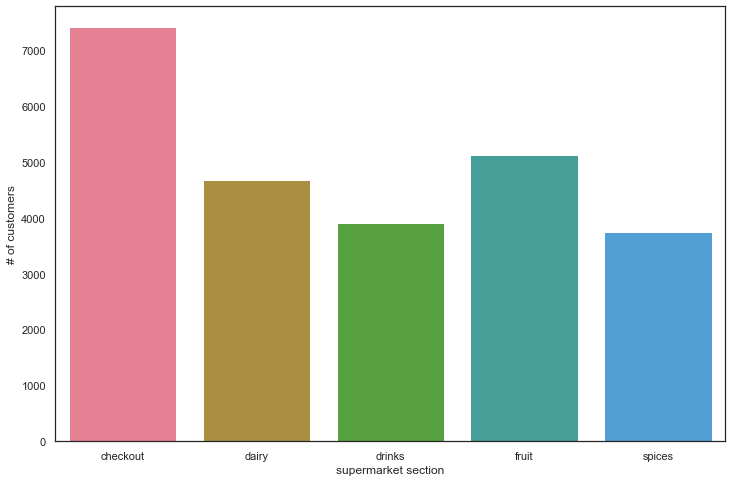

In [9]:
plt.figure(figsize=(12,8))
sns.set(style='white')
sns.set_palette('husl')
ax = sns.barplot(x=total_cust.index, y=total_cust['customer_no'], data=total_cust)
ax.set(xlabel='supermarket section', ylabel='# of customers')

## 2. Calculate the total number of customers in each section over time

In [10]:
customers_over_time = pd.DataFrame(df.groupby(['location','hour'])['customer_no'].count())
customers_over_time.fillna(0, inplace=True)
customers_over_time = pd.DataFrame(customers_over_time)
customers_over_time.reset_index(level=0, inplace=True)
customers_over_time.head(5)

,location,customer_no
hour,,
7,checkout,454
8,checkout,677
9,checkout,455
10,checkout,427
11,checkout,342


In [11]:
customers_over_time.reset_index(inplace=True)
customers_over_time

,hour,location,customer_no
0,7,checkout,454
1,8,checkout,677
2,9,checkout,455
3,10,checkout,427
4,11,checkout,342
...,...,...,...
70,17,spices,269
71,18,spices,346
72,19,spices,389
73,20,spices,246


[Text(0, 0.5, '# of customers'), Text(0.5, 0, 'time of the day [h]')]

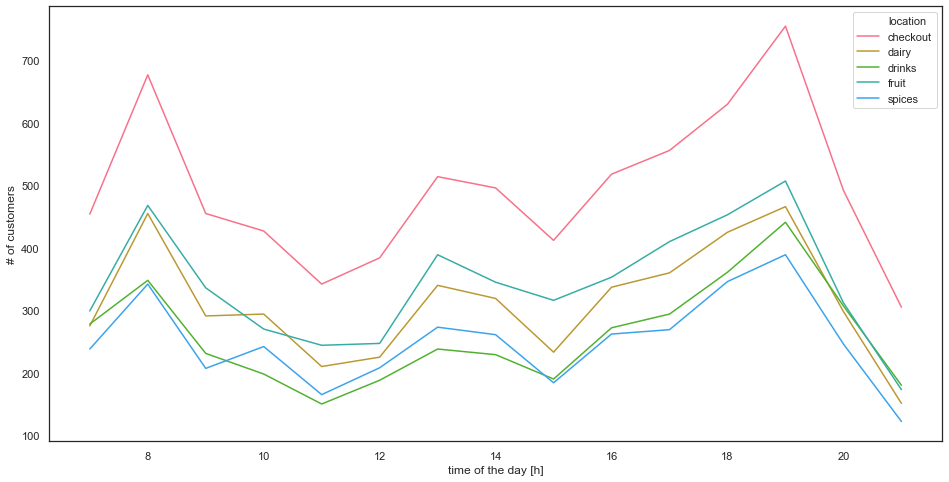

In [12]:
plt.figure(figsize=(16,8))
sns.set(style='white')
sns.set_palette('husl')
ax = sns.lineplot(x='hour', y='customer_no', hue='location', data=customers_over_time)
ax.set(xlabel='time of the day [h]', ylabel='# of customers')

## 3. Display the number of customers at checkout over time

In [13]:
checkouts_overtime = customers_over_time.loc[customers_over_time['location']=='checkout']

[Text(0, 0.5, '# of customers at checkout'),
 Text(0.5, 0, 'time of the day [h]')]

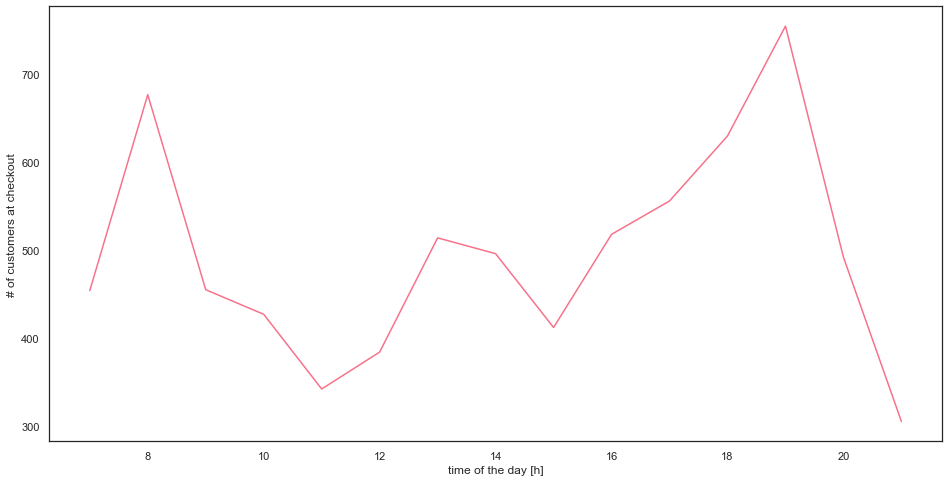

In [14]:
plt.figure(figsize=(16,8))
sns.set(style='white')
sns.set_palette('husl')
ax = sns.lineplot(x='hour', y='customer_no', data=checkouts_overtime)
ax.set(xlabel='time of the day [h]', ylabel='# of customers at checkout')

## 4. Calculate the time each customer spent in the market

In [15]:
mon['timestamp'] = pd.to_datetime(mon['timestamp'])
time_diff = pd.DataFrame(mon.groupby('customer_no').min()['timestamp'])
time_diff['exit'] = mon.groupby('customer_no').max()['timestamp']

In [16]:
time_diff['time_spent'] = time_diff['exit'] - time_diff['timestamp']
time_diff = time_diff.drop(columns=['timestamp', 'exit'])
time_diff.head()

,time_spent
customer_no,
1,00:02:00
2,00:03:00
3,00:02:00
4,00:04:00
5,00:01:00


    I don't know if creating a column like this is also a good way of getting the time spent on the market
    by each unique customer?
    
    ps: nvm, its the same thing that has been done haha. You can delete this part later if irrelevant

In [19]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [20]:
arrival = pd.DataFrame(df.groupby(['day', 'customer_no'])['timestamp'].min())
departure = pd.DataFrame(df.groupby(['day', 'customer_no'])['timestamp'].max())

In [23]:
shopping_time = pd.DataFrame(departure['timestamp'] - arrival['timestamp'])
shopping_time.reset_index(inplace=True)
shopping_time.tail(3)

,day,customer_no,timestamp
7442,4,1508,00:02:00
7443,4,1509,00:00:00
7444,4,1510,00:00:00


In [24]:
shopping_time = shopping_time[shopping_time.timestamp != '00:00:00']
shopping_time.tail(3)

,day,customer_no,timestamp
7439,4,1505,00:01:00
7441,4,1507,00:02:00
7442,4,1508,00:02:00


In [25]:
average_shopping_time = shopping_time['timestamp'].mean()
average_shopping_time

Timedelta('0 days 00:06:14.862829')

Text(0, 0.5, '# of customers')

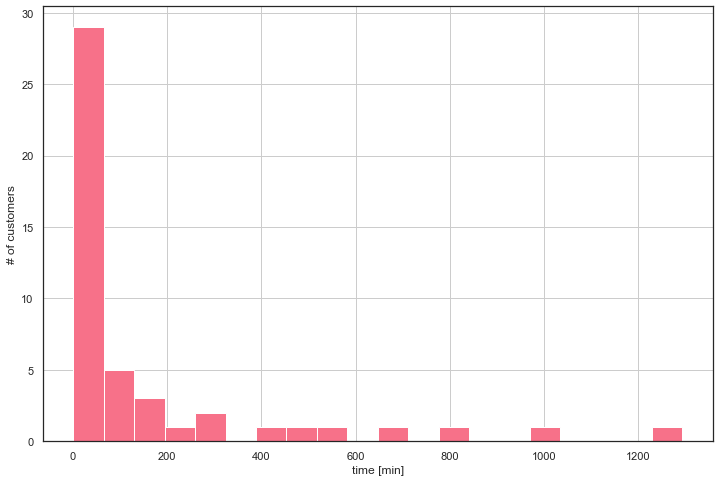

In [26]:
plt.figure(figsize=(12,8))
shopping_time['timestamp'].value_counts().hist(bins = 20)
plt.xlabel('time [min]')
plt.ylabel('# of customers')

In [27]:
cust_present = pd.DataFrame(shopping_time.reset_index().groupby('timestamp')['customer_no'].count())
cust_present.reset_index(inplace = True)
cust_present.head(3)

,timestamp,customer_no
0,00:01:00,1293
1,00:02:00,1004
2,00:03:00,822


[(-1, 1500)]

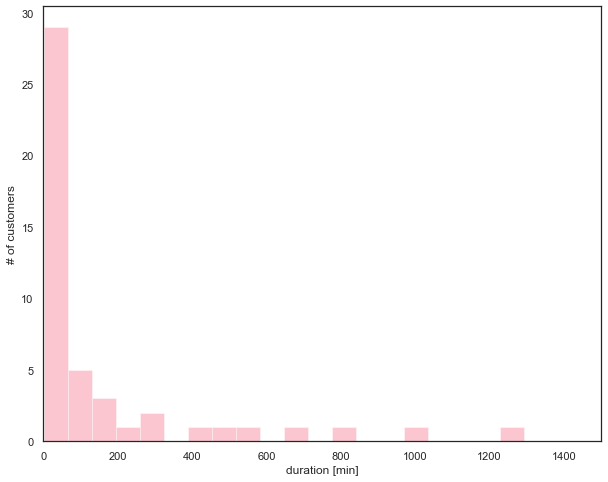

In [28]:
# Histogram using seaborn:
plt.figure(figsize=(10,8))
sns.set(color_codes=True)
sns.set(style='white', palette='husl')
ax = sns.distplot(cust_present['customer_no'], hist=True, bins=20, kde=False)
ax.set(xlabel='duration [min]', ylabel='# of customers')
ax.set(xlim=(-1, 1500))

[(-1, 1500)]

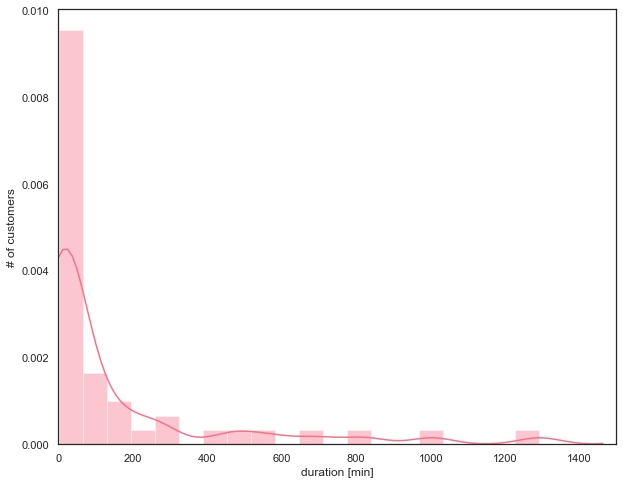

In [29]:
# This is not a histogram but a density (arae under the curve = 1):
plt.figure(figsize=(10,8))
sns.set(color_codes=True)
sns.set(style='white', palette='husl')
ax = sns.distplot(cust_present['customer_no'], hist=True, bins=20, kde=True)
ax.set(xlabel='duration [min]', ylabel='# of customers')
ax.set(xlim=(-1, 1500))

## 5. Calculate the total number of customers present in the supermarket over time.

In [44]:
total_customers_over_time = pd.DataFrame(df.groupby('timestamp').count()['customer_no'])
total_customers_over_time.reset_index(level=0, inplace=True)
total_customers_over_time['timestamp'] = pd.to_datetime(total_customers_over_time['timestamp'])
total_customers_over_time['hour'] = total_customers_over_time['timestamp'].dt.hour
total_customers_over_time.head()

,timestamp,customer_no,hour
0,2019-09-02 07:03:00,2,7
1,2019-09-02 07:04:00,6,7
2,2019-09-02 07:05:00,4,7
3,2019-09-02 07:06:00,8,7
4,2019-09-02 07:07:00,4,7


[Text(0, 0.5, '# of customers'), Text(0.5, 0, 'time of the day')]

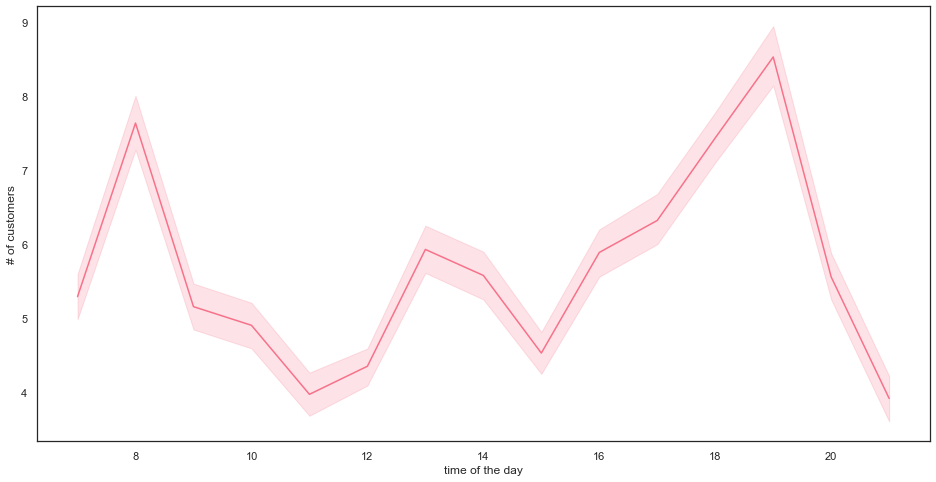

In [45]:
plt.figure(figsize=(16,8))
sns.set(style='white')
sns.set_palette('husl')
ax = sns.lineplot(x='hour', y='customer_no', data=total_customers_over_time)
ax.set(xlabel='time of the day', ylabel='# of customers')

**Max: I added a day column in here and group-counted by it just to check whether the numbers might fit. Actually I got on average ~880 customers per day, yet the Monday-table alone has 1447 customers in it.
So I went on and try to find the error.**

**Please see below, I included a new day-column, which I used with the hour to group and then summed up the customers for the hour and day. Please check whether you find this more reasonable.**

In [53]:
total_customers_over_time = pd.DataFrame(df.groupby('timestamp').count()['customer_no'])
total_customers_over_time.reset_index(level=0, inplace=True)
total_customers_over_time['timestamp'] = pd.to_datetime(total_customers_over_time['timestamp'])
total_customers_over_time['hour'] = total_customers_over_time['timestamp'].dt.hour
total_customers_over_time['day'] = total_customers_over_time['timestamp'].dt.day
total_customers_per_hour = pd.DataFrame(total_customers_over_time.groupby(['day', 'hour'])['customer_no'].sum())
total_customers_per_hour.reset_index(inplace=True)
total_customers_per_hour.head()

,day,hour,customer_no
0,2,7,317
1,2,8,364
2,2,9,308
3,2,10,282
4,2,11,189


[Text(0, 0.5, '# of customers'), Text(0.5, 0, 'time of the day')]

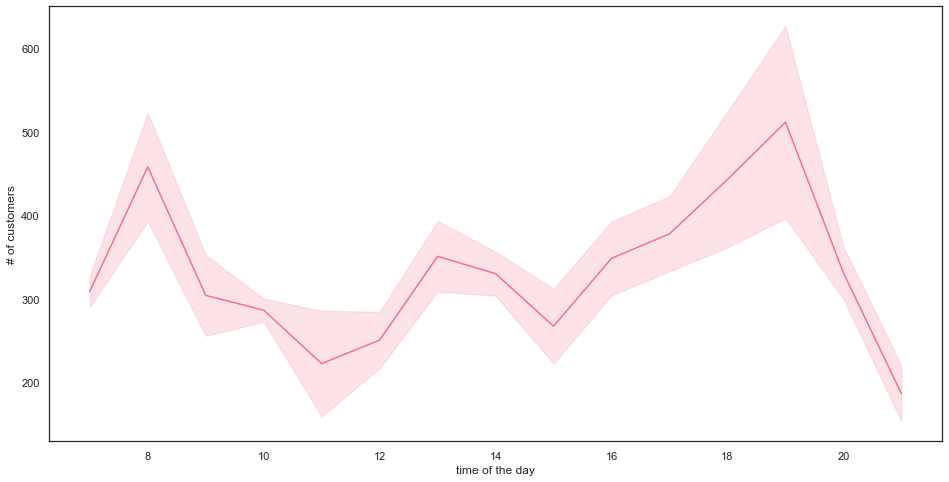

In [56]:
plt.figure(figsize=(16,8))
sns.set(style='white')
sns.set_palette('husl')
ax = sns.lineplot(x='hour', y='customer_no', data=total_customers_per_hour, ci = 'sd')
ax.set(xlabel='time of the day', ylabel='# of customers')

In [36]:
'''I don't understand this outcome, how is it possible that combining all the days of the week, 
    at 8am only 8 customers were in the market? Is this the average?'''

"I don't understand this outcome, how is it possible that combining all the days of the week, \n    at 8am only 8 customers were in the market? Is this the average?"

## 6. Analyze if the first section that customers visit follows a different pattern than the following ones

* Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”)

In [32]:
df.head(3)

,timestamp,customer_no,location,time,hour,day,month,date
datetime,,,,,,,,
2019-09-02 07:03:00,2019-09-02 07:03:00,1,dairy,07:03:00,7,0,9,2019-09-02
2019-09-02 07:03:00,2019-09-02 07:03:00,2,dairy,07:03:00,7,0,9,2019-09-02
2019-09-02 07:04:00,2019-09-02 07:04:00,3,dairy,07:04:00,7,0,9,2019-09-02


In [33]:
#these are the times when the customers enter the supermarket:
#df.groupby(['day', 'customer_no'])['time'].min()
#df['first'] = 0

In [34]:
df['before'] = df.groupby(['day', 'customer_no'])['location'].shift(1)
df.head(10)

,timestamp,customer_no,location,time,hour,day,month,date,before
datetime,,,,,,,,,
2019-09-02 07:03:00,2019-09-02 07:03:00,1,dairy,07:03:00,7,0,9,2019-09-02,NaN
2019-09-02 07:03:00,2019-09-02 07:03:00,2,dairy,07:03:00,7,0,9,2019-09-02,NaN
2019-09-02 07:04:00,2019-09-02 07:04:00,3,dairy,07:04:00,7,0,9,2019-09-02,NaN
2019-09-02 07:04:00,2019-09-02 07:04:00,4,dairy,07:04:00,7,0,9,2019-09-02,NaN
2019-09-02 07:04:00,2019-09-02 07:04:00,5,spices,07:04:00,7,0,9,2019-09-02,NaN
2019-09-02 07:04:00,2019-09-02 07:04:00,6,spices,07:04:00,7,0,9,2019-09-02,NaN
2019-09-02 07:04:00,2019-09-02 07:04:00,7,spices,07:04:00,7,0,9,2019-09-02,NaN
2019-09-02 07:04:00,2019-09-02 07:04:00,8,fruit,07:04:00,7,0,9,2019-09-02,NaN
2019-09-02 07:05:00,2019-09-02 07:05:00,1,checkout,07:05:00,7,0,9,2019-09-02,dairy
